In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
filepath='PJM_data\DEOK_hourly.csv'
DEOK_load=pd.read_csv(filepath)
DEOK_load.index = pd.to_datetime(DEOK_load['Datetime'], format='%m/%d/%Y')
DEOK_load = DEOK_load['MW']
DEOK_load.head()

Datetime
2012-01-01    2629.913043
2012-01-02    3179.875000
2012-01-03    3503.375000
2012-01-04    3470.541667
2012-01-05    3210.125000
Name: MW, dtype: float64

In [3]:
#read temperature data in Columbus, OH
OK_temp_df = pd.read_csv("PJM_data\DEOKweather.csv")

#set timestamp as index
OK_temp_df.index = pd.to_datetime(OK_temp_df['Datetime'], format='%m/%d/%Y')

OK_temp_df = OK_temp_df['TAVG']
OK_temp_df.head()

Datetime
2012-01-01    43.5
2012-01-02    26.0
2012-01-03    21.0
2012-01-04    28.5
2012-01-05    36.5
Name: TAVG, dtype: float64

In [4]:
df = pd.merge(DEOK_load, OK_temp_df, left_index=True, right_index=True)
df.head()

,MW,TAVG
Datetime,,
2012-01-01,2629.913043,43.5
2012-01-02,3179.875000,26.0
2012-01-03,3503.375000,21.0
2012-01-04,3470.541667,28.5
2012-01-05,3210.125000,36.5


In [5]:
df.tail()

,MW,TAVG
Datetime,,
2018-07-30,3359.333333,74.0
2018-07-31,3405.250000,74.0
2018-08-01,3345.375000,71.0
2018-08-02,3471.083333,72.0
2018-08-03,3281.000000,75.0


Text(0, 0.5, 'Energy (MW)')

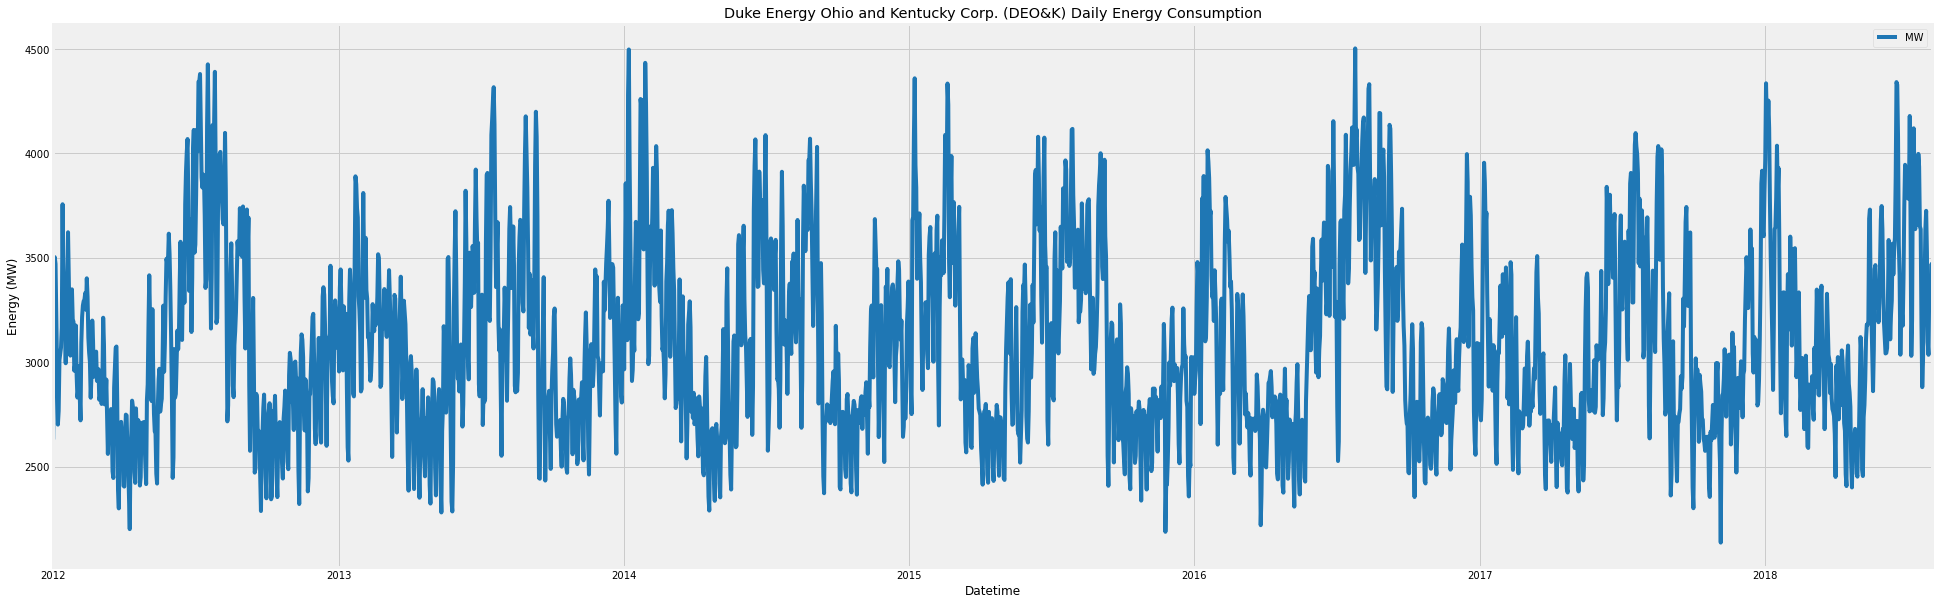

In [6]:
df.plot(y='MW', style='-',
        figsize=(30, 10),
        color=color_pal[0],
        title="Duke Energy Ohio and Kentucky Corp. (DEO&K) Daily Energy Consumption")
plt.ylabel("Energy (MW)")


Text(0, 0.5, 'Energy (MW)')

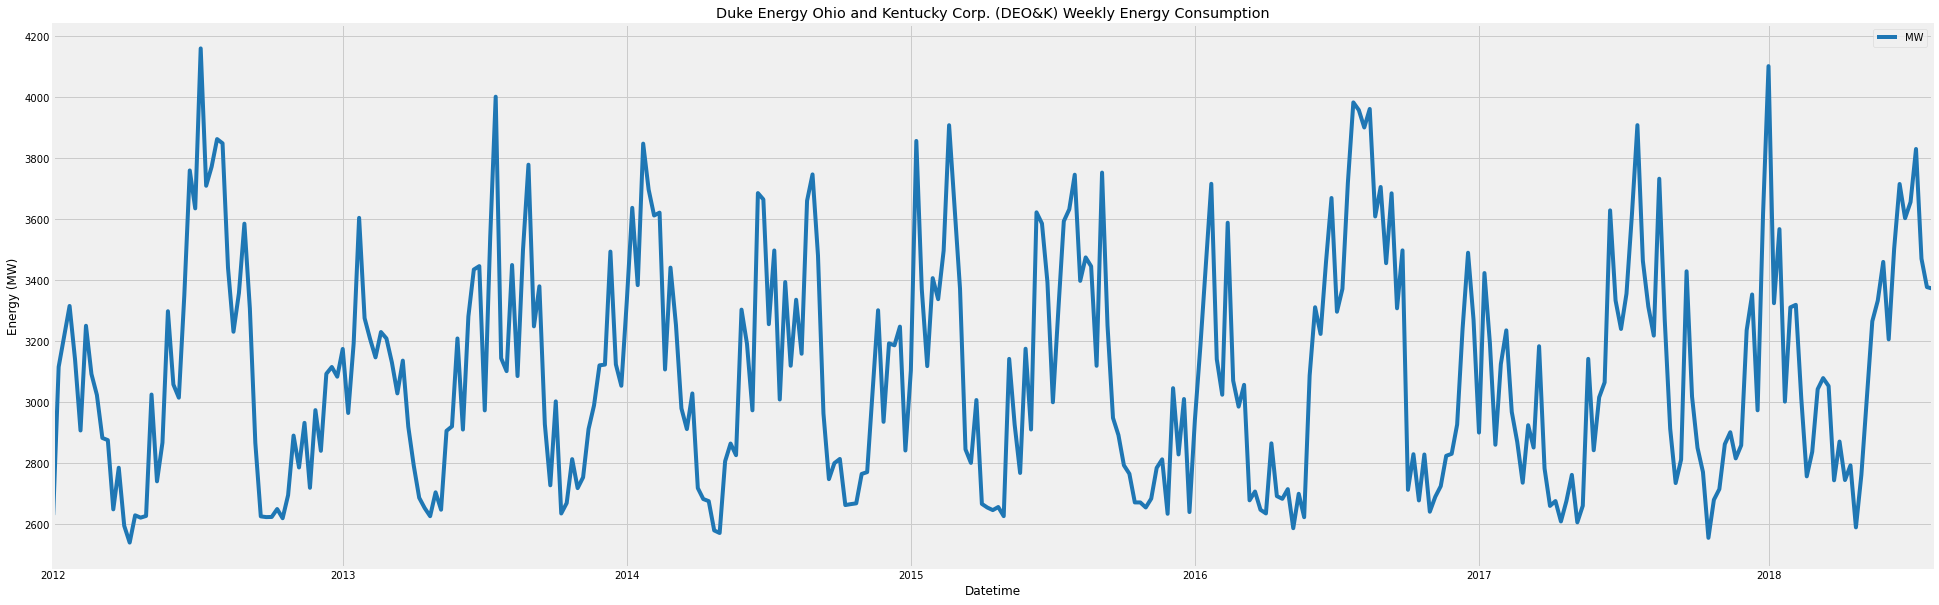

In [7]:
weekly_df = df.resample('1W').mean()
weekly_df1 = weekly_df
weekly_df.plot(y='MW', style='-',
        figsize=(30, 10),
        color=color_pal[0],
        title="Duke Energy Ohio and Kentucky Corp. (DEO&K) Weekly Energy Consumption")
plt.ylabel("Energy (MW)")



In [8]:
train = weekly_df.loc[weekly_df.index < '01-01-2017']
test = weekly_df.loc[weekly_df.index >= '01-01-2017']

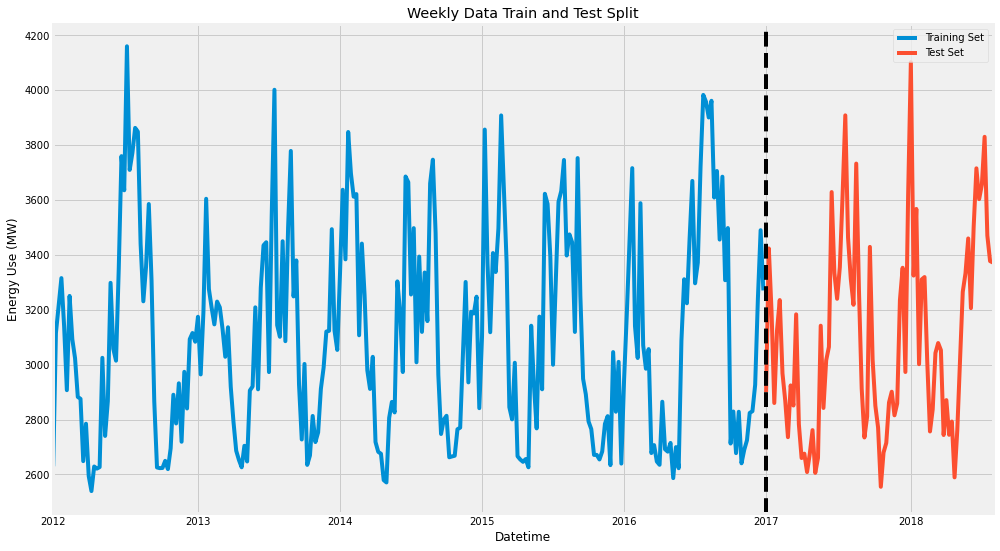

In [9]:
fig, ax = plt.subplots(figsize=(15, 9))
train.plot(y='MW', ax=ax, label= 'Training Set')
test.plot(y='MW', ax=ax, label = "Test Set")
ax.axvline('01-01-2017', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Weekly Data Train and Test Split')
ax.set_ylabel('Energy Use (MW)')
plt.show()

# ACF and PACF Graphs

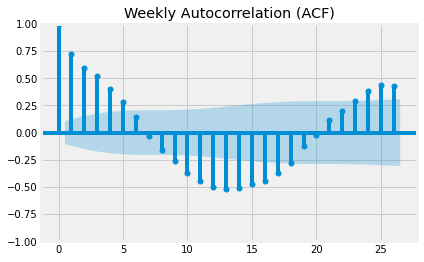

In [49]:
# Import plot_acf() function 
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load set
plot_acf(weekly_df['MW'])
plt.title('Weekly Autocorrelation (ACF)')
plt.show()


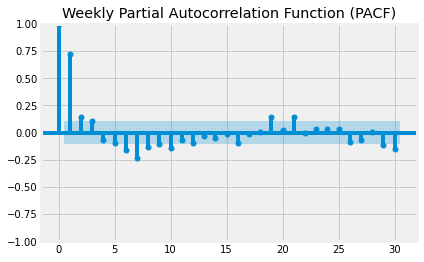

In [50]:
# import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# plot the pacf function on the monthly dataset
plot_pacf(weekly_df['MW'], lags=30)
plt.title('Weekly Partial Autocorrelation Function (PACF)')
plt.show() 

# Augmented Dickey-Fuller Test

In [51]:
ad_fuller_result = adfuller(weekly_df['MW'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -8.144995230457415
p-value: 1.0044445381509662e-12


# Feature Creation

In [52]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

weekly_df = create_features(weekly_df)

# Visualize our Feature / Target Relationship

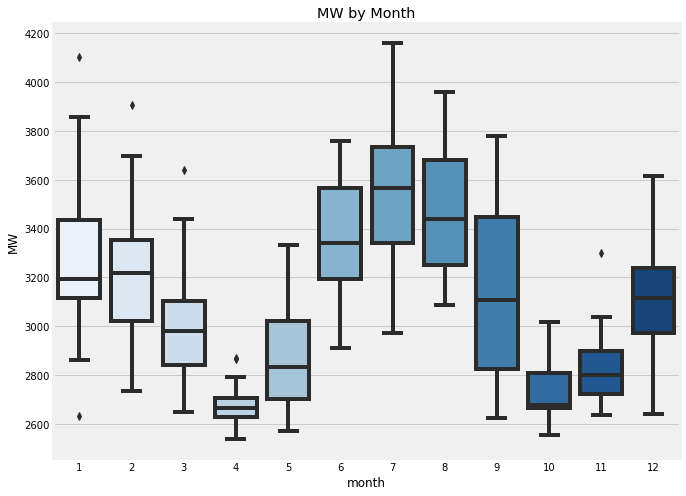

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=weekly_df, x='month', y='MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [54]:
train = create_features(train)
test = create_features(test)

FEATURES = ['TAVG','dayofyear', 'dayofweek', 'month']
TARGET = 'MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
### Import Packages ###

import itertools
import statsmodels.api as sm

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(0, 3)
d = range(1,2)
q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='W'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
sarimax_gridsearch(weekly_df['MW'], pdq, pdqs, freq='W')

#164 minutes

SARIMAX (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =4260.717356391242
SARIMAX (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =3393.6446349451353
SARIMAX (0, 1, 0) x (0, 1, 2, 52)52 : AIC Calculated =2669.4863140618863
SARIMAX (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =3448.2480458902346
SARIMAX (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =3395.462051439124
SARIMAX (0, 1, 0) x (1, 1, 2, 52)52 : AIC Calculated =2666.058708478441
SARIMAX (0, 1, 0) x (2, 1, 0, 52)52 : AIC Calculated =2686.1093439236347
SARIMAX (0, 1, 0) x (2, 1, 1, 52)52 : AIC Calculated =2674.583581462649
SARIMAX (0, 1, 0) x (2, 1, 2, 52)52 : AIC Calculated =2658.768979776434
SARIMAX (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =4133.044640727234
SARIMAX (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =3310.6308405187956
SARIMAX (0, 1, 1) x (0, 1, 2, 52)52 : AIC Calculated =2608.378744586104
SARIMAX (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =3374.3613937638934
SARIMAX (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =3311

,pdq,pdqs,aic
23,"(0, 1, 2)","(1, 1, 2, 52)",2595.049123
50,"(1, 1, 2)","(1, 1, 2, 52)",2595.388419
47,"(1, 1, 2)","(0, 1, 2, 52)",2599.640497
20,"(0, 1, 2)","(0, 1, 2, 52)",2600.197527
26,"(0, 1, 2)","(2, 1, 2, 52)",2600.236367


In [55]:
# Create and fit the SARIMA model
model = SARIMAX(y_train, order=(0, 1, 2), seasonal_order=(1, 1, 2, 52), exog= X_train)
model_fit = model.fit()

In [56]:
# Make predictions on the test set
predictions = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog= X_test)

In [57]:
predictions = pd.DataFrame(predictions)

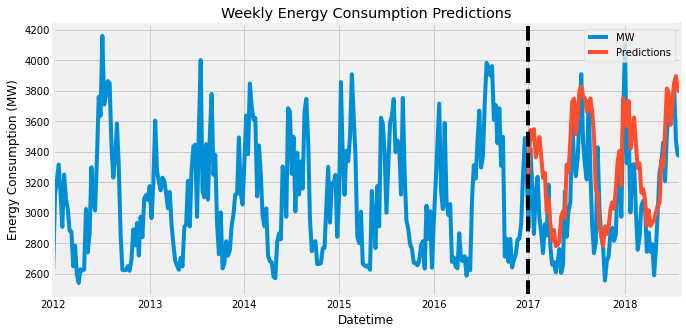

In [58]:
weekly_df = weekly_df1.merge(predictions[['predicted_mean']], how='left', left_index=True, right_index=True)
weekly_df['Predictions'] = weekly_df['predicted_mean']
ax = weekly_df[['MW']].plot(figsize=(10, 5))
weekly_df['Predictions'].plot(ax=ax)
plt.legend(['True Data', 'Predictions'])
ax.set_title('Weekly Energy Consumption Predictions')
plt.ylabel('Energy Consumption (MW)')
ax.axvline('01-01-2017', color = 'black', ls = '--')
plt.legend(loc='upper right')
plt.show()

# Feature Importance

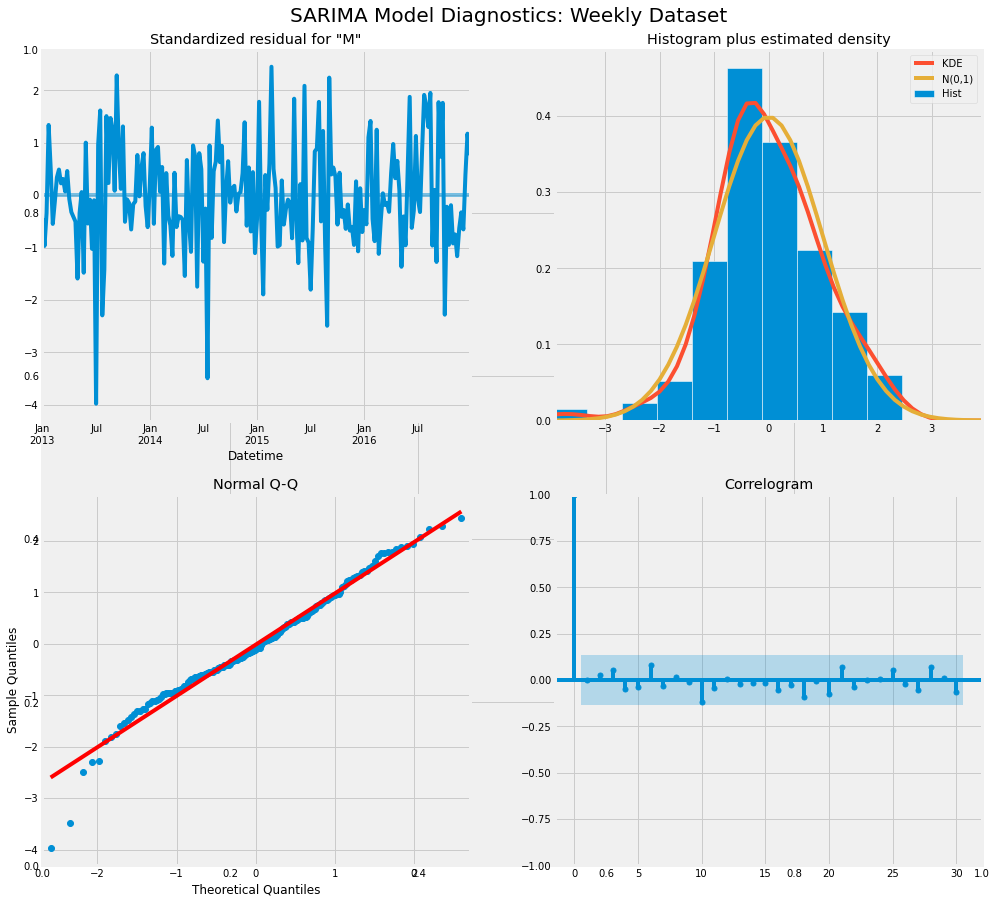

In [76]:
# Define default figure size
fig = plt.figure(figsize=(15,15))
plt.title('SARIMA Model Diagnostics: Weekly Dataset \n', fontsize = 20)
# Use plot_predict and visualize forecasts
fig = model_fit.plot_diagnostics(fig=fig, lags=30)


# Statistical Measures

In [66]:
MSE = mean_squared_error(predictions, y_test)
print(f'MSE Score on Test set: {MSE:0.2f}')

MSE Score on Test set: 93920.15


In [62]:
RMSE = np.sqrt(mean_squared_error(predictions, y_test))
print(f'RMSE Score on Test set: {RMSE:0.2f}')

RMSE Score on Test set: 306.46


In [64]:
MAE = mean_absolute_error(predictions, y_test)
print(f'MAE Score on Test set: {MAE:0.2f}')

MAE Score on Test set: 254.14


In [77]:
MAPE = mean_absolute_percentage_error(predictions, y_test)
print(f'MAPE Score on Test set: {MAPE:0.3f}')

MAPE Score on Test set: 0.076


# Calculate Error
- Look at the worst and best predicted days

### Dates Predicted with Lowest Absolute Error

In [23]:
y_test = pd.DataFrame(y_test)
y_test['error'] = np.abs(y_test['MW'] - predictions['predicted_mean'])
y_test['date'] = y_test.index
y_test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)


date
2017-10-08     0.686193
2017-10-15    11.961585
2018-05-27    14.760350
2018-07-15    22.332576
2018-07-01    27.290679
2018-05-13    31.802621
2018-03-25    33.687159
2018-07-08    40.872300
2017-04-30    51.140685
2017-12-17    52.663340
Name: error, dtype: float64

### Dates Predicted with Highest Absolute Error

In [24]:
y_test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-09-10    767.232719
2017-09-03    751.644468
2017-01-22    687.723348
2018-02-25    537.175178
2017-02-12    528.084644
2017-02-19    501.165421
2017-02-26    491.854384
2018-03-04    485.159099
2017-08-27    479.422052
2017-05-28    473.030415
Name: error, dtype: float64